In [224]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cartopy.crs as ccrs
from pyresample import geometry, grid
import pyresample
import matplotlib.pyplot as plt
import datetime
import metpy
import datetime
import xarray as xr
from pyresample import geometry, grid
import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error
import math
from skimage.transform import resize
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)

In [385]:
def matchShape(refimg, newimg_full, lats=None, lons=None):
    assert refimg.shape[0] <= newimg_full.shape[0]
    assert refimg.shape[1] <= newimg_full.shape[1]
    
    if lats != None or lons != None:
        newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    else:
        newimg = newimg_full.copy()

    nx = 0
    ny = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
    
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        
        if lats != None or lons != None:
            newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]
        else:
            newimg = newimg_full[:(newimg.shape[0] + x_add), :(newimg.shape[1] + y_add)]
    
    if lats != None or lons != None:
        lats[1] += x_add
        lons[1] += y_add
        return newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    return newimg
    
    
def shiftPixels(refimg, newimg_full, lats=None, lons=None):
    assert refimg.shape[0] <= newimg_full.shape[0]
    assert refimg.shape[1] <= newimg_full.shape[1]
    
    if lats != None or lons != None:
        newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    else:
        newimg = newimg_full.copy()
    
    nx = 0
    ny = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
        
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        
        if lats != None or lons != None:
            newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]
        else:
            newimg = newimg_full[:(newimg.shape[0] + x_add), :(newimg.shape[1] + y_add)]
    
    if lats != None or lons != None:
        lats[1] += x_add
        lons[1] += y_add

    nx = 1
    ny = 1
    x_shift = np.arange(-nx, nx+1)
    y_shift = np.arange(-ny, ny+1)
    scores = []
    
    for x in x_shift:
        for y in y_shift:
            if lats != None or lons != None:
                testimg = newimg_full[lats[0]+x:lats[1]+x+1, lons[0]+y:lons[1]+y+1]
            else:
                testimg = newimg_full[abs(x):(newimg.shape[0]+abs(x)), abs(y):(newimg.shape[1]+abs(y))]
            scores.append([x, y, np.corrcoef(refimg.flatten(), testimg.flatten())[0, 1]])
          
    max_score = 0
    min_score_index = 0
    
    for score_index in range(len(scores)-1):
        score = scores[score_index][-1]
        if abs(score) > abs(max_score):
            max_score = score
            max_score_index = score_index
            
    min_x, min_y, max_score = scores[max_score_index]
    print(min_x, min_y)
    if lats != None or lons != None:
        return newimg_full[lats[0]+min_x:lats[1]+min_x, lons[0]+min_y:lons[1]+min_y]
    return newimg_full[abs(min_x):(newimg.shape[0] + abs(min_x)), abs(min_y):(newimg.shape[1] + abs(min_y))]

def expand(refimg, newimg_full, lats, lons):
    newimg = newimg_full[lats[0]:lats[1], lons[0]:lons[1]]
    
    nx = 0
    ny = 0
    
    while refimg.shape != newimg.shape:
        x_add = 0
        y_add = 0
    
        if refimg.shape[0] > newimg.shape[0]:
            x_add += 1
            nx += 1
        elif refimg.shape[0] < newimg.shape[0]:
            x_add -= 1
            nx += 1
        if refimg.shape[1] > newimg.shape[1]:
            y_add += 1
            ny += 1
        elif refimg.shape[1] < newimg.shape[1]:
            y_add -= 1
            ny += 1
        newimg = newimg_full[lats[0]:lats[1] + nx, lons[0]:lons[1] + ny]

    lats[1] += x_add
    lons[1] += y_add

    nx = 1
    ny = 1
    x_shift = np.arange(-nx, nx+1)
    y_shift = np.arange(-ny, ny+1)
    scores = []
    
    for x in x_shift:
        for y in y_shift:
            testimg = newimg_full[lats[0]+x:lats[1]+x+1, lons[0]+y:lons[1]+y+1]
            scores.append([x, y, np.corrcoef(refimg.flatten(), testimg.flatten())[0, 1]])
          
    max_score = 0
    min_score_index = 0
    
    for score_index in range(len(scores)-1):
        score = scores[score_index][-1]
        if abs(score) > abs(max_score):
            max_score = score
            max_score_index = score_index
            
    min_x, min_y, max_score = scores[max_score_index]
    print(min_x, min_y)
    return newimg_full[lats[0]+min_x-1:lats[1]+min_x+2, lons[0]+min_y-1:lons[1]+min_y+2]

In [221]:
def load_image(array):
    """
    Returns loaded .npy file.
    
    Parameter path: Path to load .npy file from
    Precondition: path is a string
    """
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= array
    result[:,:,1]= array
    result[:,:,2]= array
    return result

def preprocess_image(array):
    """
    Returns preprocessed input array.
    
    Parameter array: array to preprocess
    Precondition: array is a numpy array
    """
    hr_image = array
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    """
    Returns low resolution image after scaling down input image using nearest neighbor downsampling.

    Parameter image: 3D of 4D tensor of preprocessed image
    Precondition: image is a tensor
    """
    height, width = image.shape
    result = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))
    smallimg = resize(image, (round(height/2), round(width/2)))
    result[:,:,0] = smallimg
    result[:,:,1] = smallimg
    result[:,:,2] = smallimg
    lr_image = tf.expand_dims(result, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

def esrgan_sharpening_img(image):
    """
    Returns dictionary containing errors after using the ESRGAN model.
    
    Parameter path: path of image not including file name
    Precondition: path is a string
    
    Parameter file: file of the image
    Precondition: file is a string of a .npy file
    """
    hr_image = preprocess_image(load_image(image))
    lr_image = downscale_image(image)
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)

    hr_image = tf.squeeze(hr_image).numpy()
    lr_image = tf.squeeze(lr_image).numpy()
#     lr_image = resize(lr_image, (hr_image.shape[0], hr_image.shape[1], 3)).ravel()
#     fake_image = resize(fake_image.numpy(), (hr_image.shape[0], hr_image.shape[1], 3))

    return np.mean(fake_image, axis=2)

In [356]:
landsat_path = '../landsat_files/landsat_files/'
goes_path = '../landsat_files/'
goes_red = np.load(goes_path + 'OR_ABI-L1b-RadC-M6C02_G17_s20212401846176_e20212401848549_c20212401848572.npy')

In [392]:
pc = ccrs.PlateCarree()
pc_params = pc.proj4_params
pc_extents = [-124.25, 32.25, -114.25, 42.25]
shape = [500, 500]
target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, pc_extents)

latlon1A = [40.49, -121.45]
latlon2A = [40.650000000000006, -121.17]
coords1A = target_area.get_array_coordinates_from_lonlat(latlon1A[1], latlon1A[0])
coords1A = (round(coords1A[0]), round(coords1A[1]))
coords2A = target_area.get_array_coordinates_from_lonlat(latlon2A[1], latlon2A[0])
coords2A = (round(coords2A[0]), round(coords2A[1]))
lonsA = [coords1A[0], coords2A[0]]
latsA = [coords2A[1], coords1A[1]]

latlon1B = [39.91, -120.97]
latlon2B = [40.13, -120.49000000000001]
coords1B = target_area.get_array_coordinates_from_lonlat(latlon1B[1], latlon1B[0])
coords1B = (round(coords1B[0]), round(coords1B[1]))
coords2B = target_area.get_array_coordinates_from_lonlat(latlon2B[1], latlon2B[0])
coords2B = (round(coords2B[0]), round(coords2B[1]))
lonsB = [coords1B[0], coords2B[0]]
latsB = [coords2B[1], coords1B[1]]

-1 0
-1 0


Text(0.5, 1.0, 'GOES Image Original B')

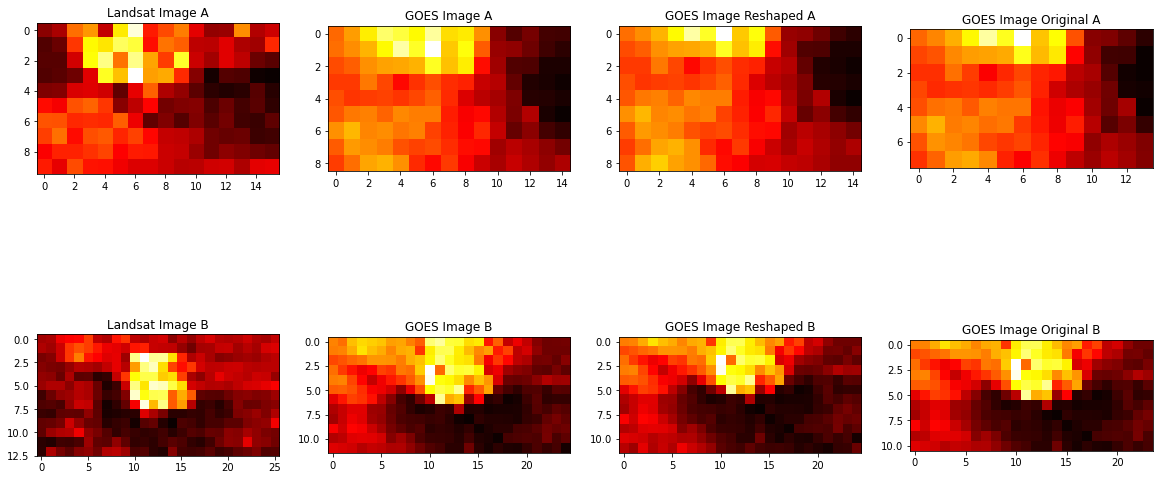

In [393]:
landsat_img_red_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridAcent0.02deg.npy'))
goes_img_red_A = shiftPixels(landsat_img_red_A, goes_red, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_reshaped_red_A = matchShape(landsat_img_red_A, goes_red, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_original_red_A = goes_red[latsA[0]:latsA[1], lonsA[0]:lonsA[1]]

landsat_img_red_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridBcent0.02deg.npy'))
goes_img_red_B = shiftPixels(landsat_img_red_B, goes_red, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
goes_img_reshaped_red_B = matchShape(landsat_img_red_B, goes_red, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
goes_img_original_red_B = goes_red[latsB[0]:latsB[1], lonsB[0]:lonsB[1]]

f, (ax1, ax2) = plt.subplots(2, 4, figsize=(20, 10))
ax1[0].imshow(landsat_img_red_A, vmin = landsat_img_red_A.min(), vmax = landsat_img_red_A.max(), cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(goes_img_red_A, vmin = goes_img_red_A.min(), vmax = goes_img_red_A.max(), cmap='hot')
ax1[1].set_title('GOES Image A')
ax1[2].imshow(goes_img_reshaped_red_A, vmin = goes_img_reshaped_red_A.min(), vmax = goes_img_reshaped_red_A.max(), cmap='hot')
ax1[2].set_title('GOES Image Reshaped A')
ax1[3].imshow(goes_img_original_red_A, vmin = goes_img_original_red_A.min(), vmax = goes_img_original_red_A.max(), cmap='hot')
ax1[3].set_title('GOES Image Original A')

ax2[0].imshow(landsat_img_red_B, vmin = landsat_img_red_B.min(), vmax = landsat_img_red_B.max(), cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(goes_img_red_B, vmin = goes_img_red_B.min(), vmax = goes_img_red_B.max(), cmap='hot')
ax2[1].set_title('GOES Image B')
ax2[2].imshow(goes_img_reshaped_red_B, vmin = goes_img_reshaped_red_B.min(), vmax = goes_img_reshaped_red_B.max(), cmap='hot')
ax2[2].set_title('GOES Image Reshaped B')
ax2[3].imshow(goes_img_original_red_B, vmin = goes_img_original_red_B.min(), vmax = goes_img_original_red_B.max(), cmap='hot')
ax2[3].set_title('GOES Image Original B')

-1 0
-1 0
0 0
0 -1


Text(0.5, 1.0, 'GOES Image Original B')

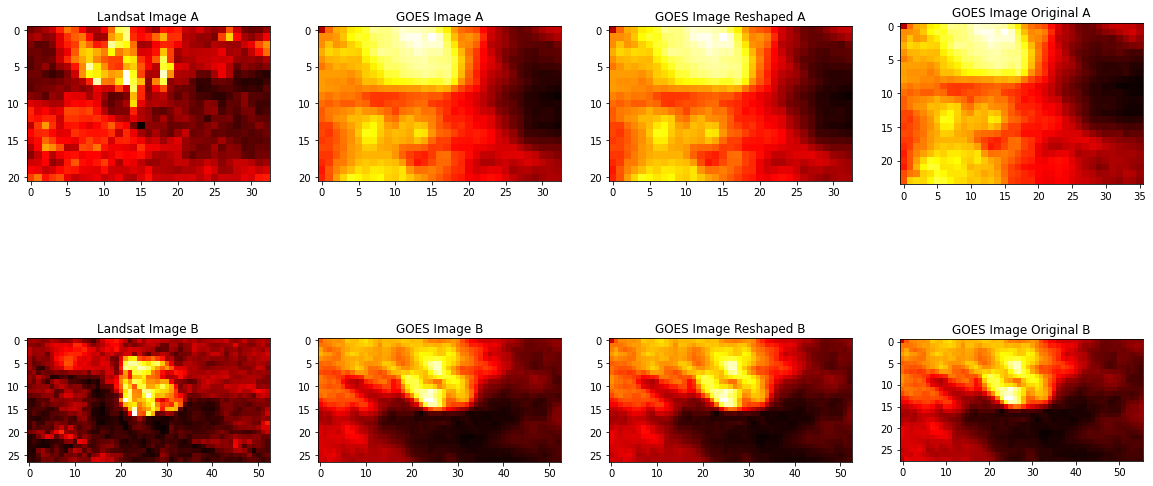

In [396]:
landsat_img_red_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridAcent0.02deg.npy'))
goes_img_expanded_red_A = expand(landsat_img_red_A, goes_red, [latsA[0], latsA[1]], [lonsA[0], lonsA[1]])
goes_img_original_red_A = esrgan_sharpening_img(goes_img_expanded_red_A)

landsat_img_red_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridBcent0.02deg.npy'))[:12, :26]
goes_img_expanded_red_B = expand(landsat_img_red_B, goes_red, [latsB[0], latsB[1]], [lonsB[0], lonsB[1]])
goes_img_original_red_B = esrgan_sharpening_img(goes_img_expanded_red_B)

landsat_img_red_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridAcent0.01deg.npy'))
goes_img_red_A = shiftPixels(landsat_img_red_A, goes_img_original_red_A)
goes_img_reshaped_red_A = matchShape(landsat_img_red_A, goes_img_original_red_A)

landsat_img_red_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridBcent0.01deg.npy'))
goes_img_red_B = shiftPixels(landsat_img_red_B, goes_img_original_red_B)
goes_img_reshaped_red_B = matchShape(landsat_img_red_B, goes_img_original_red_B)

f, (ax1, ax2) = plt.subplots(2, 4, figsize=(20, 10))
ax1[0].imshow(landsat_img_red_A, vmin = landsat_img_red_A.min(), vmax = landsat_img_red_A.max(), cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(goes_img_red_A, vmin = goes_img_red_A.min(), vmax = goes_img_red_A.max(), cmap='hot')
ax1[1].set_title('GOES Image A')
ax1[2].imshow(goes_img_reshaped_red_A, vmin = goes_img_reshaped_red_A.min(), vmax = goes_img_reshaped_red_A.max(), cmap='hot')
ax1[2].set_title('GOES Image Reshaped A')
ax1[3].imshow(goes_img_original_red_A, vmin = goes_img_original_red_A.min(), vmax = goes_img_original_red_A.max(), cmap='hot')
ax1[3].set_title('GOES Image Original A')

ax2[0].imshow(landsat_img_red_B, vmin = landsat_img_red_B.min(), vmax = landsat_img_red_B.max(), cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(goes_img_red_B, vmin = goes_img_red_B.min(), vmax = goes_img_red_B.max(), cmap='hot')
ax2[1].set_title('GOES Image B')
ax2[2].imshow(goes_img_reshaped_red_B, vmin = goes_img_reshaped_red_B.min(), vmax = goes_img_reshaped_red_B.max(), cmap='hot')
ax2[2].set_title('GOES Image Reshaped B')
ax2[3].imshow(goes_img_original_red_B, vmin = goes_img_original_red_B.min(), vmax = goes_img_original_red_B.max(), cmap='hot')
ax2[3].set_title('GOES Image Original B')

0 -1
0 -1


Text(0.5, 1.0, 'GOES Image Original B')

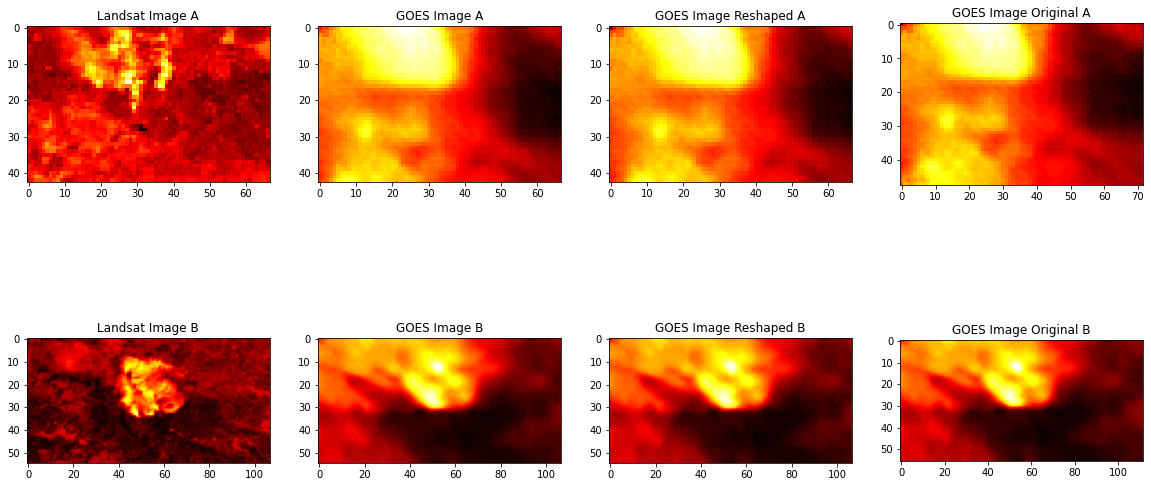

In [395]:
goes_img_original_red_A = esrgan_sharpening_img(goes_img_original_red_A)
landsat_img_red_A = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridAcent0.005deg.npy'))
goes_img_red_A = shiftPixels(landsat_img_red_A, goes_img_original_red_A)
goes_img_reshaped_red_A = matchShape(landsat_img_red_A, goes_img_original_red_A)

goes_img_original_red_B = esrgan_sharpening_img(goes_img_original_red_B)
landsat_img_red_B = np.flipud(np.load(landsat_path + 'LC08_L2SP_044032_20210828_20210901_02_T1_goesLS_red_gridBcent0.005deg.npy'))
goes_img_red_B = shiftPixels(landsat_img_red_B, goes_img_original_red_B)
goes_img_reshaped_red_B = matchShape(landsat_img_red_B, goes_img_original_red_B)

f, (ax1, ax2) = plt.subplots(2, 4, figsize=(20, 10))
ax1[0].imshow(landsat_img_red_A, vmin = landsat_img_red_A.min(), vmax = landsat_img_red_A.max(), cmap='hot')
ax1[0].set_title('Landsat Image A')
ax1[1].imshow(goes_img_red_A, vmin = goes_img_red_A.min(), vmax = goes_img_red_A.max(), cmap='hot')
ax1[1].set_title('GOES Image A')
ax1[2].imshow(goes_img_reshaped_red_A, vmin = goes_img_reshaped_red_A.min(), vmax = goes_img_reshaped_red_A.max(), cmap='hot')
ax1[2].set_title('GOES Image Reshaped A')
ax1[3].imshow(goes_img_original_red_A, vmin = goes_img_original_red_A.min(), vmax = goes_img_original_red_A.max(), cmap='hot')
ax1[3].set_title('GOES Image Original A')

ax2[0].imshow(landsat_img_red_B, vmin = landsat_img_red_B.min(), vmax = landsat_img_red_B.max(), cmap='hot')
ax2[0].set_title('Landsat Image B')
ax2[1].imshow(goes_img_red_B, vmin = goes_img_red_B.min(), vmax = goes_img_red_B.max(), cmap='hot')
ax2[1].set_title('GOES Image B')
ax2[2].imshow(goes_img_reshaped_red_B, vmin = goes_img_reshaped_red_B.min(), vmax = goes_img_reshaped_red_B.max(), cmap='hot')
ax2[2].set_title('GOES Image Reshaped B')
ax2[3].imshow(goes_img_original_red_B, vmin = goes_img_original_red_B.min(), vmax = goes_img_original_red_B.max(), cmap='hot')
ax2[3].set_title('GOES Image Original B')

Text(0, 0.5, 'Landsat Values')

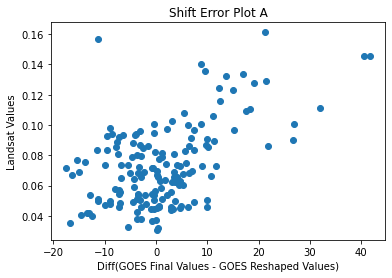

In [209]:
plt.scatter(goes_img_red_A-goes_img_reshaped_red_A, landsat_img_red_A)
plt.title('Shift Error Plot A')
plt.xlabel('Diff(GOES Final Values - GOES Reshaped Values)')
plt.ylabel('Landsat Values')

Text(0, 0.5, 'Landsat Values')

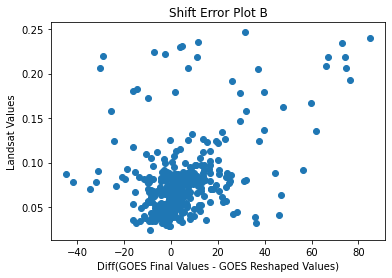

In [212]:
plt.scatter(goes_img_red_B-goes_img_reshaped_red_B, landsat_img_red_B)
plt.title('Shift Error Plot B')
plt.xlabel('Diff(GOES Final Values - GOES Reshaped Values)')
plt.ylabel('Landsat Values')